## Feature Ideas

This task has a high degree of conceptual overlap with `engage`. For that reason, we will reuse
many of the engage features + add a few more badge-specific features.

- **Engage feature set** (row per user, timestamp; excluding some unimportant features):
    - User-level features:
        - `userId`
        - `timestamp`
        - `months_since_account_creation`
        - `num_badges`
        - `weeks_since_last_badge`
        - `badge_score`: sum of log(1 / badge_incidence) -- captures a total of badges weighted by their rarity. Eg: let's say a user has two badges, one that 5% of users have and another that 1% of users have, then the badge_score is log(20) + log(100)
    - Question feats:
        - last_question (feats as of the last question asked by user, NULL if not exists):
            - `weeks_ago`: how many weeks ago did the user post their last question 
            - `num_tags`
            - `body_length`
            - `avg_commenter_badge_score`
        - questions_last_yr (aggregate feats over questions asked by user in the last year, NULL otherwise):
            - `num_questions_last_6mo`
            - `avg_has_accepted_ans`
            - `avg_num_tags`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_commenter_badge_score`
    - Answer feats:
        - last_answer (feats as of the last answer posted by user, NULL if not exists)
            - `weeks_ago`: how many weeks ago did the user post their last answer 
            - `body_length`
            - `avg_commenter_badge_score`
        - answers_last_yr (aggregate feats over answeres posted by user in the last year, NULL otherwise):
            - `num_answeres_last_3mo`
            - `acceptance_rate`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_commenter_badge_score`
    - Extra badge features:
        - `last_badge_rarity`: rarity as defined in badge score, ie `log(1 / badge_incidence)`
        - `last_badge_name`
        - `max_rarity`
        - `avg_rarity`
        - `rarest_badge_weeks_ago`
        - `avg_badge_age`
        - `avg_time_bw_badges`
        - `avg_badge_rarity`
        - `badge_momentum`: An exponential moving average of badge rarity (a recent rare badge > an old rare badge)

In [1]:
cd ..

/lfs/hyperion/0/adobles/relbench-user-study/stack_exchange


In [2]:
import duckdb
import numpy as np
from relbench.datasets import get_dataset
from torch_frame import TaskType, stype
from torch_frame.gbdt import LightGBM, XGBoost
from torch_frame.data import Dataset
from torch_frame.typing import Metric
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('stackex.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False

In [3]:
%%sql
select 
    avg(WillGetBadge),
    count(*)
from badges_train

avg(WillGetBadge),count_star()
0.29954158316633267,399200


In [4]:
%%sql
select
    badges.UserId,
    first(badges.Name order by badges.Date asc) as first_badge,
    last(badges.Name order by badges.Date asc) as last_badge
from badges
group by badges.UserId
limit 10

UserId,first_badge,last_badge
40865,Student,Popular Question
28506,Student,Caucus
40799,Editor,Yearling
40884,Editor,Nice Question
38053,Editor,Popular Question
40846,Editor,Student
24786,Student,Yearling
11657,Scholar,Yearling
3396,Teacher,Announcer
40909,Supporter,Autobiographer


## Tuning

In [7]:
with open('badges/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [3]:
train_df = conn.sql('select * from badges_train_feats').df()
val_df = conn.sql('select * from badges_val_feats').df()

In [4]:
col_to_stype = infer_df_stype(train_df)
col_to_stype

{'user_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'WillGetBadge': <stype.categorical: 'categorical'>,
 'months_since_account_creation': <stype.categorical: 'categorical'>,
 'num_badges': <stype.numerical: 'numerical'>,
 'badge_score': <stype.numerical: 'numerical'>,
 'max_rarity': <stype.numerical: 'numerical'>,
 'avg_rarity': <stype.numerical: 'numerical'>,
 'last_badge_name': <stype.categorical: 'categorical'>,
 'rarest_badge_age_weeks': <stype.categorical: 'categorical'>,
 'last_badge_rarity': <stype.numerical: 'numerical'>,
 'last_badge_weeks_ago': <stype.categorical: 'categorical'>,
 'avg_badge_age_weeks': <stype.numerical: 'numerical'>,
 'avg_weeks_bw_badges': <stype.numerical: 'numerical'>,
 'badge_momentum': <stype.numerical: 'numerical'>,
 'weeks_since_last_comment': <stype.categorical: 'categorical'>,
 'num_comments': <stype.numerical: 'numerical'>,
 'num_posts_commented': <stype.numerical: 'numerical'>,
 'avg_comment_length': <stype.n

In [5]:
DROP_COLS = [
    # drop identifier cols
    'user_id',
    'timestamp',
]
for c in DROP_COLS:
    del col_to_stype[c]
# Correct certain columns
col_to_stype['months_since_account_creation'] = stype.numerical
col_to_stype['rarest_badge_age_weeks'] = stype.numerical
col_to_stype['last_badge_weeks_ago'] = stype.numerical
col_to_stype['weeks_since_last_comment'] = stype.numerical
col_to_stype['last_q_weeks_ago'] = stype.numerical
col_to_stype['last_q_num_tags'] = stype.numerical

In [6]:
train_dset = Dataset(
    train_df.drop(DROP_COLS, axis=1),
    col_to_stype=col_to_stype,
    target_col='WillGetBadge'
).materialize()
val_tf = train_dset.convert_to_tensor_frame(val_df.drop(DROP_COLS, axis=1))
tune_metric = Metric.ROCAUC
print(train_dset.tensor_frame.num_cols, train_dset.tensor_frame.num_rows)

44 399200


In [15]:
gbdt = XGBoost(TaskType.BINARY_CLASSIFICATION, num_classes=2, metric=tune_metric)
gbdt.tune(tf_train=train_dset.tensor_frame, tf_val=val_tf, num_trials=10, device='cuda')

[I 2024-04-23 13:00:07,626] A new study created in memory with name: no-name-3c71862b-9e73-45e0-a863-b1f9e159c5d3
[I 2024-04-23 13:00:09,412] Trial 0 finished with value: 0.7885342113059455 and parameters: {'use_lambda': True, 'lambda': 0.0076150435596177395, 'use_alpha': False, 'max_depth': 6, 'min_child_weight': 1783.8075836982105, 'subsample': 0.6590433635017934, 'colsample_bytree': 0.6394001932222686, 'colsample_bylevel': 0.7918838275151138, 'use_gamma': True, 'gamma': 0.2619048458997969, 'learning_rate': 0.00022981511769591312}. Best is trial 0 with value: 0.7885342113059455.
[I 2024-04-23 13:00:32,235] Trial 1 finished with value: 0.8152168356059257 and parameters: {'use_lambda': True, 'lambda': 0.0189234598529033, 'use_alpha': False, 'max_depth': 5, 'min_child_weight': 0.0027562602302613837, 'subsample': 0.593284331924113, 'colsample_bytree': 0.940215036961096, 'colsample_bylevel': 0.9838185252769226, 'use_gamma': False, 'learning_rate': 0.002060086847381928}. Best is trial 1 wi

In [16]:
gbdt.save('data/badges_xgb.json')

## Val Eval

In [17]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, average_precision_score, accuracy_score, PrecisionRecallDisplay

In [15]:
(
    utils
    .feature_summary_df(val_df.drop(DROP_COLS, axis=1), 'WillGetBadge')
    .style
    .format('{:.3f}', subset=['Label Corr.', 'Label MI'])
    .format('{:.1%}', subset=['NaN %'])
    .background_gradient(subset=['Label MI'])
)

,Label Corr.,Label MI,NaN %
max_rarity,0.319,0.088,0.0%
num_badges,0.272,0.063,0.0%
avg_rarity,0.268,0.100,0.0%
badge_score,0.228,0.105,0.0%
num_questions_last_yr,0.227,0.043,87.1%
last_badge_rarity,0.219,0.095,55.0%
avg_weeks_bw_badges,0.218,0.075,77.1%
badge_momentum,0.217,0.080,0.0%
avg_comment_length,0.204,0.083,0.0%
avg_num_tags,0.125,0.056,87.1%


In [18]:
pred = gbdt.predict(tf_test=val_tf)

In [19]:
auc = gbdt.compute_metric(val_tf.y, pred)
y_ = val_tf.y.numpy()
pred_ = pred.numpy()
ap = average_precision_score(y_, pred_)
acc = accuracy_score(y_, (pred_ > 0.5))

print(f"AUC: {auc:.3f}")
print(f"AP: {ap:.3f}")
print(f"Accuracy: {acc:.3f}")

AUC: 0.826
AP: 0.698
Accuracy: 0.845


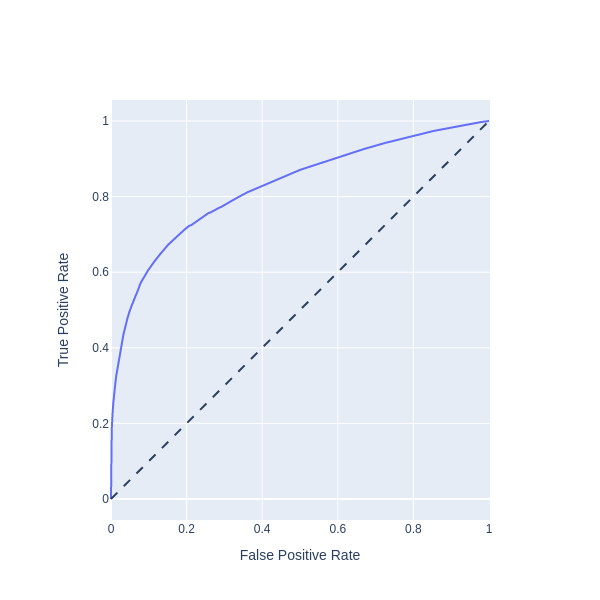

In [20]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fpr, tpr, thresholds = roc_curve(y_, pred_)
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode='lines')
)
fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=600, height=600
)
fig.show(renderer='png')

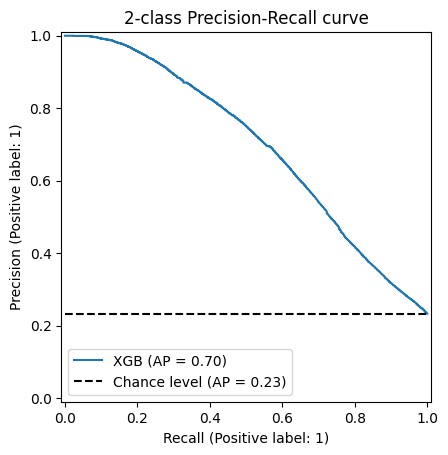

In [21]:
display = PrecisionRecallDisplay.from_predictions(
    y_, pred_, name='XGB', plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [22]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

In [23]:
val_arr, _, _ = gbdt._to_xgboost_input(val_tf[:10_000])
shap_values = explainer.shap_values(val_arr, pred_[:10_000])

In [24]:
# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

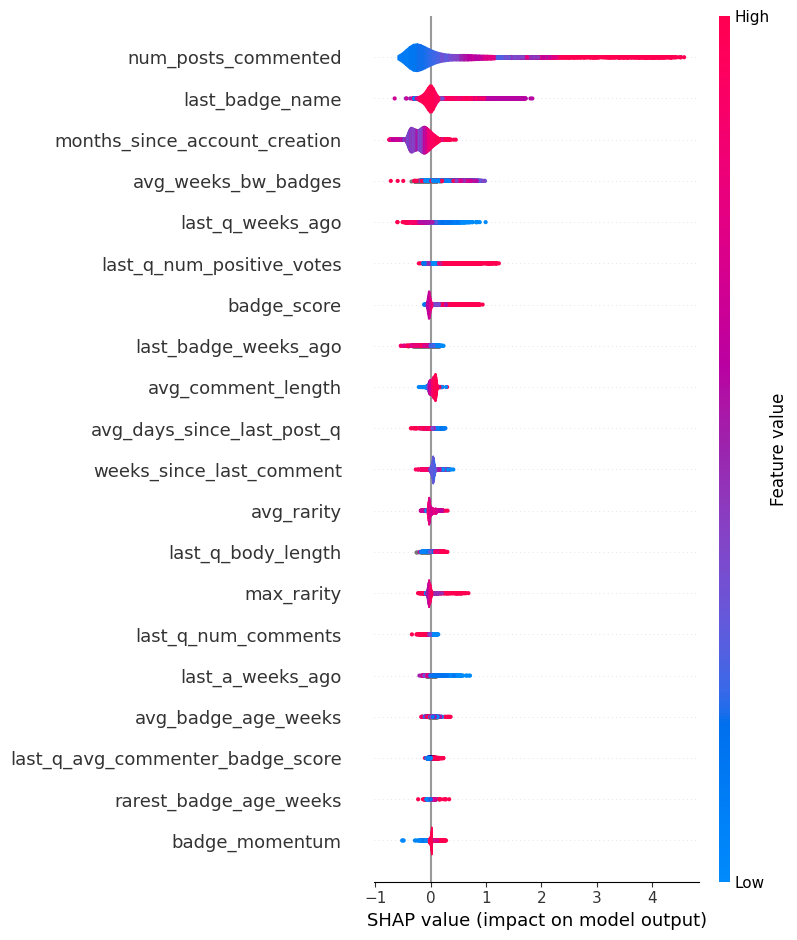

In [25]:
shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=20,
                  feature_names=feat_names)

## Test Eval

In [26]:
from relbench.datasets import get_dataset

task = (
    get_dataset('rel-math-stackex', process=True, cache_dir='data/')
    .get_task('rel-stackex-badges', process=True)
)

making Database object from raw files...
Loading data from: /lfs/hyperion/0/adobles/relbench-user-study/stack_exchange/data/25a03b9a227fa6fadbd949a4ea4721f2-relbench-stackex-raw/math-stackex-temp


/lfs/hyperion/0/adobles/relbench/relbench/datasets/math_stackex.py:56: DtypeWarning:

Columns (0,1,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.

/lfs/hyperion/0/adobles/relbench/relbench/datasets/math_stackex.py:62: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Data loaded
Percentage of rows removed due to invalid dates: 4.21%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
done in 230.11 seconds.
reindexing pkeys and fkeys...
done in 37.04 seconds.


In [27]:
test_df = conn.sql('select * from badges_test_feats').df()
test_tf = train_dset.convert_to_tensor_frame(test_df.drop(DROP_COLS, axis=1))

In [28]:
task.test_table.df.head()

,timestamp,UserId
0,2021-01-01,173235
1,2021-01-01,1541
2,2021-01-01,107796
3,2021-01-01,3298
4,2021-01-01,137098


In [29]:
pred = gbdt.predict(tf_test=test_tf)
preds = {uid: p for uid, p in zip(test_df.user_id, pred)}
pred = np.array([preds[uid] for uid in task.test_table.df.UserId])

In [30]:
task.evaluate(pred)

{'average_precision': 0.6385876274586451,
 'accuracy': 0.8590258610481057,
 'f1': 0.571723097784727,
 'roc_auc': 0.8247649724721953}

In [ ]:
conn.close()